In [1]:
import os
from dataclasses import dataclass

from IPython.display import Markdown
from dotenv import load_dotenv
from azure.core.credentials import AzureKeyCredential
from azure.ai.documentintelligence import DocumentIntelligenceClient
from azure.ai.documentintelligence.models import (
    ContentFormat,
    AnalyzeDocumentRequest,
    DocumentAnalysisFeature,
)
USE_DOC_INTEL_PREVIEW_VERSION = True
DOC_INTEL_MODEL_ID = "prebuilt-layout" # E.g. "prebuilt-read", "prebuilt-layout", or "prebuilt-document"

# Possible Document Intelligence features
# v4.0 (Preview): ['ocrHighResolution', 'languages', 'barcodes', 'formulas', 'styleFont', 'keyValuePairs', 'queryFields']
# v3.3 (GA):      ['ocrHighResolution', 'languages', 'barcodes', 'formulas', 'styleFont']
DOC_INTEL_FEATURES = ['ocrHighResolution', 'languages', 'styleFont']

DOC_INTEL_ENDPOINT = os.getenv("AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT")
DOC_INTEL_API_KEY = os.getenv("AZURE_DOCUMENT_INTELLIGENCE_API_KEY")

In [2]:
di_client = DocumentIntelligenceClient(
        endpoint=DOC_INTEL_ENDPOINT, 
        credential=AzureKeyCredential(DOC_INTEL_API_KEY),
        api_version="2024-07-31-preview",
    )
enabled_features = [DocumentAnalysisFeature(feature) for feature in DOC_INTEL_FEATURES]



In [3]:
pdf_path = "../raw_documents/pdf/oral_cancer_text_5th_table&image.pdf"

In [4]:
import base64

def convert_pdf_to_base64(pdf_path: str):
    # Read the PDF file in binary mode, encode it to base64, and decode to string
    with open(pdf_path, "rb") as file:
        base64_encoded_pdf = base64.b64encode(file.read()).decode()
    return base64_encoded_pdf
analyze_request = AnalyzeDocumentRequest(bytes_source=convert_pdf_to_base64(pdf_path))

poller = di_client.begin_analyze_document(
            model_id=DOC_INTEL_MODEL_ID,
            analyze_request=analyze_request,
            output_content_format=ContentFormat.MARKDOWN,
            features=enabled_features
        )
analyzedDocumentResult = poller.result()

In [5]:
import sys
import os
from dotenv import load_dotenv

load_dotenv("/home/azureuser/slm-fine-tune-private-domain-kb-generation/.env")
sys.path.append(os.path.abspath(os.path.join('..')))
markdown_img_tag_path_or_url = os.getenv("MARKDOWN_IMG_TAG_PATH_OR_URL")

In [6]:
from docProcess.customizedProcess.markdownImageTagFigureProcessor import MarkdownImageTagDocumentFigureProcessor
from docProcess.azureDocIntelligResultPostProcessor import DocumentIntelligenceResultPostProcessor
from docProcess.fileTools import extract_pdf_page_images, load_pymupdf_pdf

# config the figure processor
figure_processor = MarkdownImageTagDocumentFigureProcessor(
    before_figure_text_formats=["*Figure Caption:* {caption}"],
    output_figure_img=True,
    figure_img_text_format="*Figure Content:*\n{content}",
    after_figure_text_formats=None,
    markdown_img_tag_path_or_url=markdown_img_tag_path_or_url
)

# config the post processor with markdown figure processor
doc_intel_result_processor = DocumentIntelligenceResultPostProcessor(
    figure_processor = figure_processor)

pdf = load_pymupdf_pdf(pdf_path=pdf_path, pdf_url=None)
doc_page_imgs = extract_pdf_page_images(pdf, img_dpi=100, starting_idx=1)

processed_content_docs = doc_intel_result_processor.process_analyze_result(
        analyzedDocumentResult,
        doc_page_imgs=doc_page_imgs
    )


*Page 1 content:*

nodes in the head and neck are subdivided into specific ana- tomic subsites and grouped into seven levels for ease of description (Fig. 5.1, Tables 5.1 and 5.2).
In addition to the standard groups listed in Tables 5.1 and 5.2, other lymph node groups are defined by their specific anatomic location. Numbers of nodes are counted toward N category, but they are listed separately using the following descriptors.
· Suboccipital
· Retropharyngeal
· Parapharyngeal
· Buccinator (facial)
· Preauricular
· Periparotid and intraparotid



# **Other General Rules for Assessing Regional Lymph Nodes**

Histopathologic examination is necessary to exclude the presence of tumor in lymph nodes for pathological categorization (pNO). No imaging study (as yet) can iden- tify microscopic tumor foci in regional nodes or distin- guish between small reactive nodes and small malignant nodes.


*Figure Caption:* Fig. 5.1 Schematic indicating the location of the lymph node levels in the neck as described in Table 5.1

![](../processed_documents/img/388c018a28d935a74620b2d8b2fcb16d_img.png)


**Table 1 Info**

*Table Caption:* Table 5.1 Anatomical structures defining the boundaries of the neck levels and sublevels
*Table Footnotes:* Modified from Robbins KT, Clayman G, Levine PA, et al.,13 with permission from the American Medical Association.
*Table Content:*


| Boundary Level   | Superior                                                                 | Inferior                                                                 | Anterior (medial)                                                                          | Posterior (lateral)                                                           |
|------------------|--------------------------------------------------------------------------|--------------------------------------------------------------------------|--------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------|
| IA               | Symphysis of the mandible                                                | Body of the hyoid                                                        | Anterior belly of the contralateral digastric muscle                                       | Anterior belly of the ipsilateral digastric muscle                            |
| IB               | Body of the mandible                                                     | Posterior belly of the diagastric muscle                                 | Anterior belly of the digastric muscle                                                     | Stylohyoid muscle                                                             |
| IIA              | Skull base                                                               | Horizontal plane defined by the inferior border of the hyoid bone        | Stylohyoid muscle                                                                          | Vertical plane defined by the spinal accessory nerve                          |
| IIB              | Skull base                                                               | Horizontal plane defined by the inferior body of the hyoid bone          | Vertical plane defined by the spinal accessory nerve                                       | Lateral border of the sternocleidomastoideole                                 |
| III              | Horizontal plane defined by the inferior body of the hyoid               | Horizontal plane defined by the inferior border of the cricoid cartilage | Lateral border of the sternohyoid muscle                                                   | Lateral border of the sternocleidomastoideory branches of the cervical plexus |
| IV               | Horizontal plane defined by the inferior border of the cricoid cartilage | Clavicle                                                                 | Lateral border of the sternohyoid muscle                                                   | Lateral border of the sternocleidomastoideory branches of the cervical plexus |
| VA               | Apex of the convergence of the sternocleidomastoideo trapezius muscles   | Horizontal plane defined by the lower border of the cricoid cartilage    | Posterior border of the sternocleidomastoideole or sensory branches of the cervical plexus | Anterior border of the trapezius muscle                                       |
| VB               | Horizontal plane defined by the lower border of the cricoid cartilage    | Clavicle                                                                 | Posterior border of the sternocleidomastoideole                                            | Anterior border of the trapezius muscle                                       |
| VI               | Hyoid bone                                                               | Suprasternal notch                                                       | Common carotid artery                                                                      | Common carotid artery                                                         |
| VII              | Suprasternal notch                                                       | Innominate artery                                                        | Sternum                                                                                    | Trachea, esophagus, and prevertebral fascia                                   |


5


*Page 1 Image:*

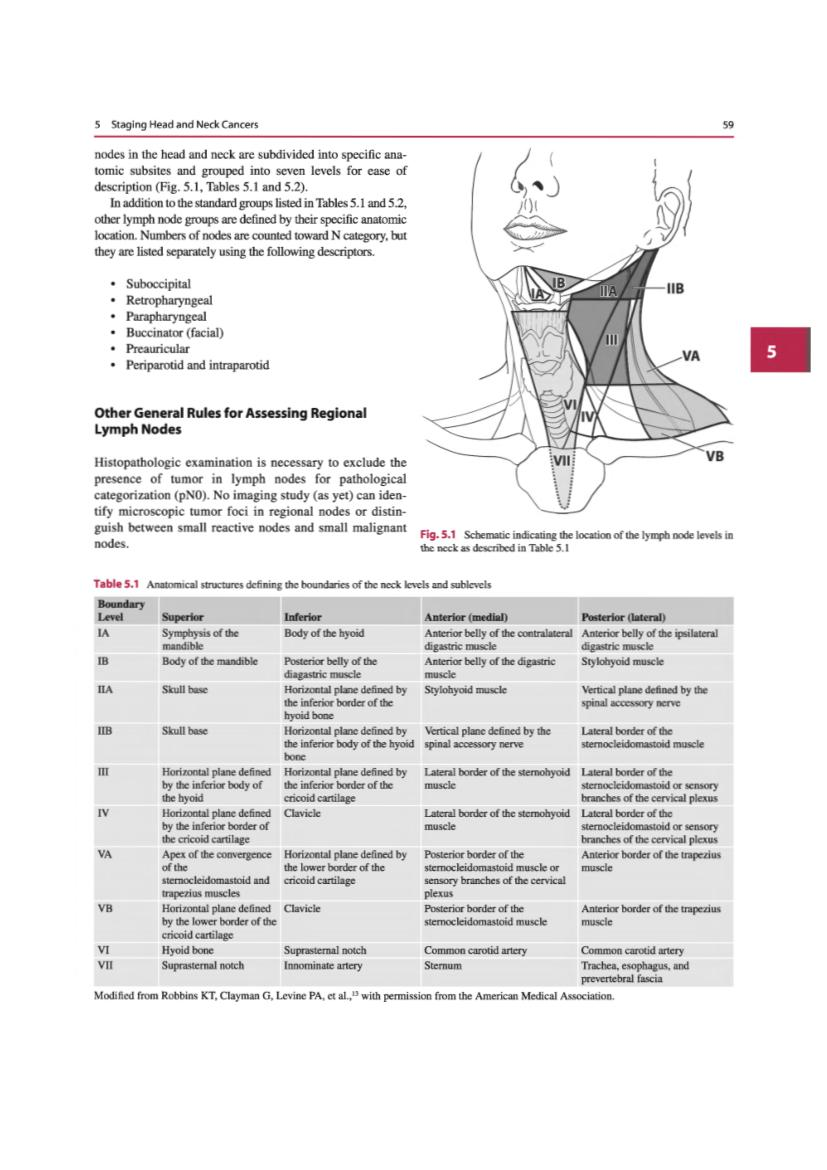

In [9]:
from docProcess.docIntelligElementTools import convert_processed_di_docs_to_markdown

processed_content_md = convert_processed_di_docs_to_markdown(processed_content_docs, default_text_merge_separator="\n")

Markdown(processed_content_md)